# Procedural generation

A notebook for poking at procedural generation techniques.

**TODO:**
- delaunay triangulation
- minimal spanning trees
- voronoi cells
- diffusion-limited aggregation
- maze generation algorithms
- wave function collapse
- biome mapping
- unreachable area culling
- varied tunnels

## Setup

This section sets things used later by the generators we use later in the notebook.


### Imports

We use `matplotlib` for the rendering of the maps, and open simplex for noise generation.

In [ ]:
# imports

import copy
import dataclasses
import random
import typing

import matplotlib.pyplot
import opensimplex


### Constants

Some constants used in the generators.

* `WIDTH` and `HEIGHT` are the dimensions of the map.
* `AIR` AND `WALL` are the tile values for air and wall tiles.

In [ ]:
# constants

WIDTH = 200
HEIGHT = 200

AIR = 1
WALL = 0


### Types

The following are some simple types used in this notebook.

In [ ]:
type Map = list[list[int]]

type Rect = tuple[int, int, int, int]  # x, y, width, height


#### Brush

Drawing parameters.

In [ ]:
@dataclasses.dataclass
class Brush:
    size: int = 1
    value: int = AIR
    symmetry: typing.Literal["none", "horizontal", "vertical", "both"] = "none"


#### Context

Contains information related to dungeon generation.

In [ ]:
@dataclasses.dataclass
class Context:
    seed: int
    data: Map
    x: int
    y: int
    width: int
    height: int
    rng: random.Random

    def subcontext(
        self,
        x: int,
        y: int,
        width: int,
        height: int,
    ) -> typing.Self:
        return Context(
            seed=self.seed,
            data=self.data,
            x=self.x + x,
            y=self.y + y,
            width=width,
            height=height,
            rng=self.rng,
        )

    def draw(
        self,
        x: int,
        y: int,
        brush: Brush,
    ) -> int:
        ox = self.x + x - brush.size // 2
        oy = self.y + y - brush.size // 2

        result = 0

        for ix in range(ox, ox + brush.size):
            for iy in range(oy, oy + brush.size):
                if ix < 0 or ix >= self.x + self.width or iy < 0 or iy >= self.y + self.height:
                    continue

                if self.data[iy][ix] != brush.value:
                    result += 1

                self.data[iy][ix] = brush.value

                mx = self.x + self.width - ix - 1
                my = self.y + self.height - iy - 1

                if brush.symmetry == "horizontal" or brush.symmetry == "both":
                    if self.data[iy][mx] != brush.value:
                        result += 1

                    self.data[iy][mx] = brush.value

                if brush.symmetry == "vertical" or brush.symmetry == "both":
                    if self.data[my][ix] != brush.value:
                        result += 1

                    self.data[my][ix] = brush.value

                if brush.symmetry == "both":
                    if self.data[my][mx] != brush.value:
                        result += 1

                    self.data[my][mx] = brush.value

        return result

    def neighbours_for(self, x: int, y: int, value: int) -> int:
        count = 0

        for dx in range(-1, 2):
            for dy in range(-1, 2):
                nx = self.x + x + dx
                ny = self.y + y + dy

                if (
                    nx < 0 or
                    nx > self.x + self.width - 1 or
                    ny < 0 or
                    ny > self.y + self.height - 1 or
                    self.data[ny][nx] == value
                ):
                    count += 1

        return count

    def count_of(
        self,
        value: int = WALL
    ) -> int:
        return sum(
            1
            for y in range(self.y, self.y + self.height)
            for x in range(self.x, self.x + self.width)
            if self.data[y][x] == value
        )

    def size(self) -> int:
        return self.width * self.height

    def random_point(self) -> tuple[int, int]:
        return self.rng.randint(0, self.width - 1), self.rng.randint(0, self.height - 1)

    def copy(self) -> typing.Self:
        return Context(
            seed=self.seed,
            data=copy.deepcopy(self.data),
            x=self.x,
            y=self.y,
            width=self.width,
            height=self.height,
            rng=self.rng,
        )


#### Generator

Generators are the main type used in this notebook. They are functions that when given
a region of a map, will populate it with `WALL` and `AIR` tiles.

In [ ]:
class Generator(typing.Protocol):
    def __call__(
        self,
        context: Context
    ) -> None:
        """
        Generator

        :param context: map context
        """


#### Room generators

Room generators are functions that return a set of rectangles representing rooms on
a map. They are used in room based generation.

In [ ]:

class RoomGenerator(typing.Protocol):
    def __call__(
        self,
        context: Context
    ) -> list[Rect]:
        """
        Room Generator

        :param context: map context

        :return: list of room bounding boxes
        """


#### Edge generators

Edge generations are functions that return a set of edges corresponding to the indexes
of the passed rooms, they represent the connections between rooms.

In [ ]:

class EdgeGenerator(typing.Protocol):
    def __call__(
        self,
        rooms: list[Rect],
        context: Context
    ) -> list[tuple[int, int]]:
        """
        Edge generator

        :param rooms: list of room bounding boxes
        :param context: map context

        :return: list of connections between rooms
        """


#### Tunnel generator

Tunnel generators are functions that will add air and wall tiles to the map to form 
tunnels between the center points of two rooms.

They generate the tunnels for the edges generated by the edge generators.

In [ ]:

class TunnelGenerator(typing.Protocol):
    def __call__(
        self,
        context: Context,
        x1: int,
        y1: int,
        x2: int,
        y2: int,
    ) -> None:
        """
        Tunnel generator

        :param context: map context
        :param x1: x coordinate of the first room
        :param y1: y coordinate of the first room
        :param x2: x coordinate of the second room
        :param y2: y coordinate of the second room
        """


### Rendering

This function renders a map, it takes a two dimensional list of tile values and a
color map and renders the map with matplotlib.


In [ ]:
# render output

def render_data(
    data: Map,
    colormap: str | None = "binary_r",
    title: str | None = None
) -> None:
    # remove all the axis and cruft from the graph so we can use it to draw a map
    _, axis = matplotlib.pyplot.subplots(figsize=(6, 6))

    matplotlib.pyplot.cla()

    if title is not None:
        axis.set_title(title)

    axis.set_xticklabels([])
    axis.set_yticklabels([])
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_aspect('equal')
    axis.spines[["top", "right", "bottom", "left"]].set_visible(False)

    axis.imshow(data, cmap=colormap, interpolation='nearest')


def render(
    generator: Generator,
    colormap: str | None = "binary_r",
    width: int = WIDTH,
    height: int = HEIGHT,
    title: str | None = None,
    seed: int | None = None,
) -> None:
    # generate the map using a seeded random number generator and a map of wall tiles
    if seed is None:
        seed = random.randint(0, 2 ** 64 - 1)

    rng = random.Random(seed)

    data = []
    for _ in range(height):
        data.append([WALL] * width)

    context = Context(seed, data, 0, 0, width, height, rng)

    generator(context)

    render_data(data, colormap, title)


### Helpers

Some helper functions used by the generators.

#### Center for rect

Calculates the approximate center point of a rectangle.


In [ ]:

def center_for_rect(
    x: int,
    y: int,
    w: int,
    h: int
) -> tuple[int, int]:
    # return the center of the rectangle

    return (x + w // 2, y + h // 2)


#### Chain

Chain several generators together and overlay their results on top of each other.

In [ ]:
def chain(*generators: Generator) -> Generator:
    def generator(
        context: Context
    ) -> None:
        for func in generators:
            func(context)

    return generator


## Basic generators

### Random Choice

This example selects tiles to carve out at random. It is the most simple example of a
procedurally generated map, but its result is chaotic and not interesting at all.

Overall this is not a viable strategy.

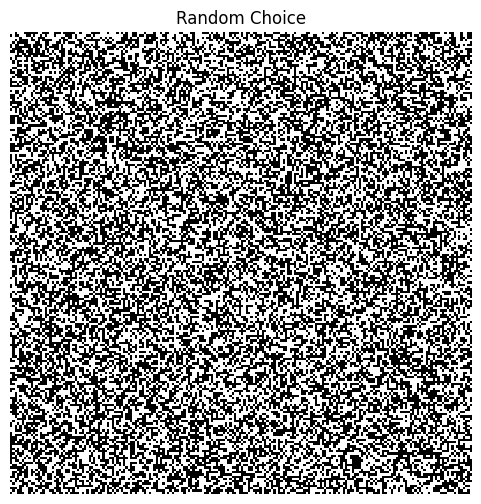

In [ ]:
def generate_random(ratio: float = 0.5, brush: Brush = Brush()) -> Generator:

    def generator(context: Context) -> None:
        for x in range(0, context.width):
            for y in range(0, context.height):
                if context.rng.random() <= ratio:
                    context.draw(x, y, brush)

    return generator


render(generate_random(ratio=0.5), title="Random Choice")


### Random Placement

This examples places random tiles on the map, it is effectively the same as the random
choice generator, but will be faster for smaller fill ratios, and potentially much
slower on higher fill ratios.

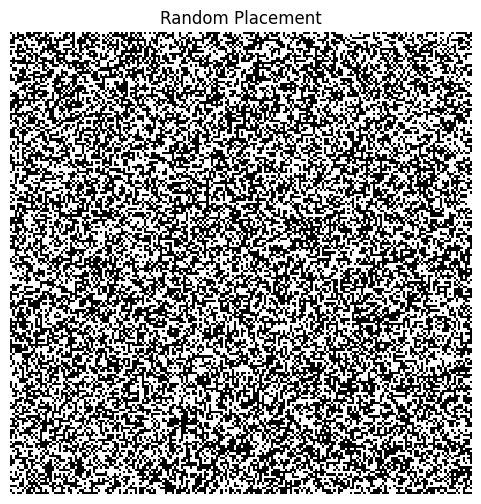

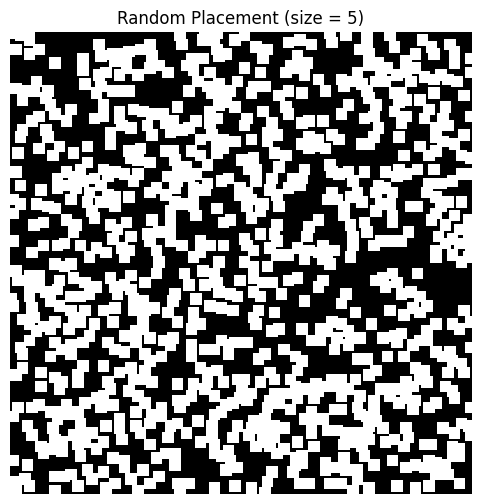

In [ ]:

def generate_random_placement(ratio: float = 0.5, brush: Brush = Brush()) -> Generator:

    def generator(context: Context) -> None:
        total = context.size()
        count = context.count_of(brush.value)

        while count / total < ratio:
            x, y = context.random_point()

            if context.data[y][x] == WALL:
                count += context.draw(x, y, brush)

    return generator


render(generate_random_placement(ratio=0.5), title="Random Placement")

render(generate_random_placement(ratio=0.5, brush=Brush(size=5)),
       title="Random Placement (size = 5)")


### Simplex Noise

[Simplex Noise](https://en.wikipedia.org/wiki/Simplex_noise) is a type of 
[gradient noise](https://en.wikipedia.org/wiki/Gradient_noise). It generates random
values that tend to be more similar to their neighbours than value noise, which makes
things look smoother and more natural.

By rounding the values generated by a gradient noise function we get a map that is more
interesting with smooth natural looking edges.

The downside is that the carved out areas are not contiguous, which makes the strategy
unviable on its own, but could potentially be combined with some form of tunnel carving
to provide a viable map.

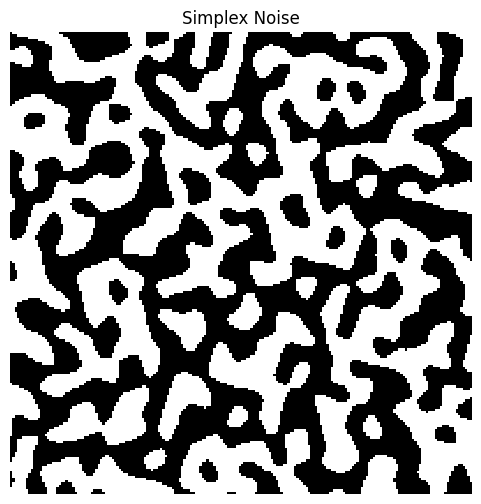

In [ ]:
def generate_simplex(scale: float = 0.1, brush: Brush = Brush()) -> Generator:

    def generator(context: Context) -> None:
        generator = opensimplex.OpenSimplex(
            context.rng.randint(0, 2 ** 64 - 1))

        for x in range(0, context.width):
            for y in range(0, context.height):
                if generator.noise2(x * scale, y * scale) > 0:
                    context.draw(x, y, brush)

    return generator


render(generate_simplex(scale=0.1), title="Simplex Noise")


### Drunkards Walk

The drunkards walk algorithm is a type of random walk, where an miner moves in a random
direction each step, carving out the map as it goes, until it ultimately passes out and
a new miner is spawned at the start point.

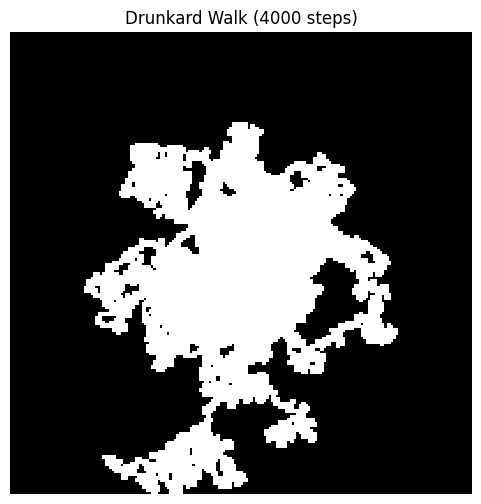

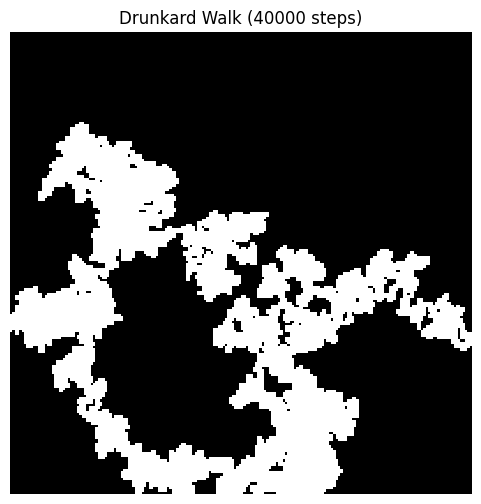

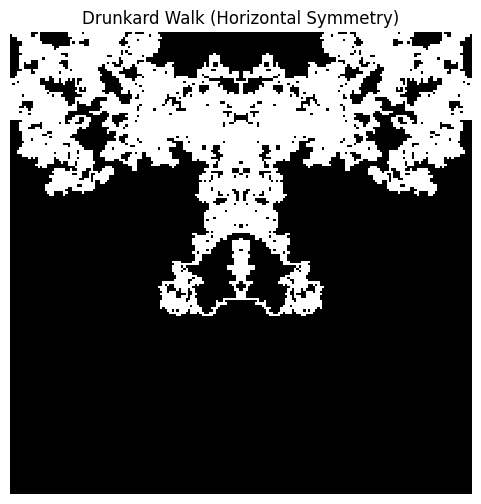

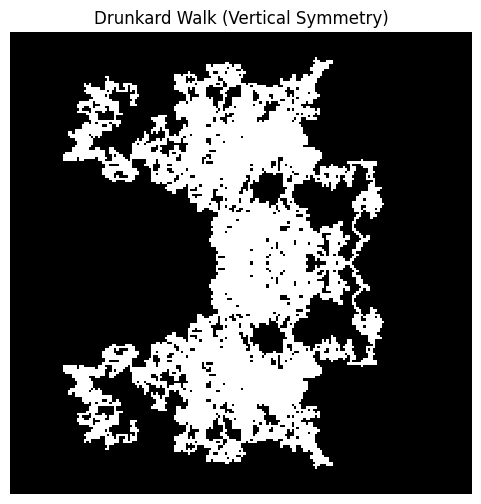

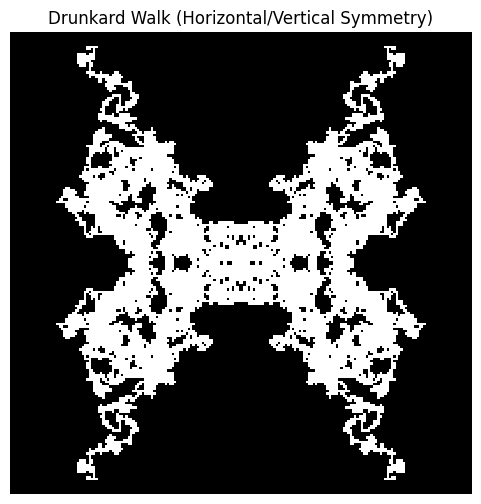

In [ ]:
def generate_drunkard(ratio: float = 0.25, max_steps: int = 50000, max_walkers: int = 100, brush: Brush = Brush(size=2)) -> Generator:

    def generator(context: Context) -> None:
        total = context.size()
        count = context.count_of(brush.value)

        defaults = (context.width // 2, context.height // 2, max_steps)

        x, y, steps = defaults

        walkers = 0

        while count / total < ratio:
            count += context.draw(x, y, brush)

            match context.rng.randint(0, 3):
                case 0:
                    x += 1
                case 1:
                    x -= 1
                case 2:
                    y += 1
                case 3:
                    y -= 1

            x = max(0, min(context.width - 1, x))
            y = max(0, min(context.height - 1, y))

            steps -= 1

            if steps == 0:
                x, y, steps = defaults
                walkers += 1

                if walkers >= max_walkers:
                    break

    return generator


render(
    generate_drunkard(ratio=0.25, max_steps=4000),
    title="Drunkard Walk (4000 steps)",
)


render(
    generate_drunkard(ratio=0.25, max_steps=40000),
    title="Drunkard Walk (40000 steps)",
)


render(
    generate_drunkard(ratio=0.25, max_steps=40000,
                      brush=Brush(symmetry="horizontal")),
    title="Drunkard Walk (Horizontal Symmetry)",
)

render(
    generate_drunkard(ratio=0.25, max_steps=40000,
                      brush=Brush(symmetry="vertical")),
    title="Drunkard Walk (Vertical Symmetry)",
)

render(
    generate_drunkard(ratio=0.25, max_steps=40000,
                      brush=Brush(symmetry="both")),
    title="Drunkard Walk (Horizontal/Vertical Symmetry)",
)


### Framed

A simple generator that adds a frame to the output of an existing generator.

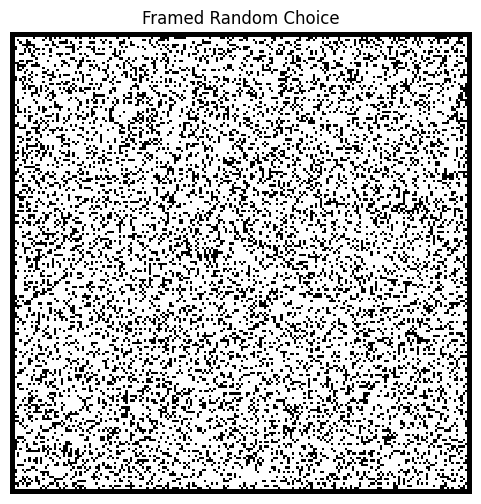

In [ ]:
def generate_frame(brush: Brush = Brush(size=1, value=WALL)) -> Generator:

    def generator(context: Context) -> None:
        o1 = brush.size // 2
        o2 = brush.size - o1

        for x in range(0, context.width):
            context.draw(x, o1, brush)
            context.draw(x, context.height - o2, brush)

        for y in range(0, context.height):
            context.draw(o1, y, brush)
            context.draw(context.width - o2, y, brush)

    return generator


render(
    chain(
        generate_random(ratio=0.75),
        generate_frame(brush=Brush(size=2, value=WALL)),
    ),
    title="Framed Random Choice"
)


### Filled

A simple generator that fills the map with a single tile value. In isolation this is
possibly the least interesting of all generators.

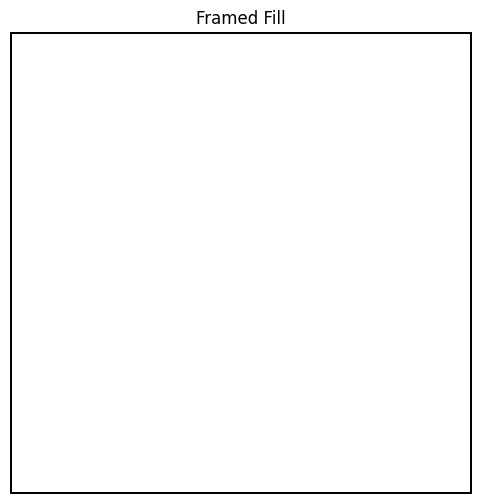

In [ ]:
def generate_fill(value: int = AIR) -> Generator:
    brush = Brush(value=value)

    def generator(context: Context) -> None:
        for x in range(0, context.width):
            for y in range(0, context.height):
                context.draw(x, y, brush)

    return generator


render(chain(generate_fill(), generate_frame()), title="Framed Fill")


### Cellular Automata

Cellular automata are most famously used in conway's game of life, the map is iteratively
transformed based on some simple rules about the neighbourhood of 9 tiles it belongs to.

When fed a random map, the automata will carve out interesting patterns, but the results 
are not always contiguous spaces.

The automata also tend to have a smoothing on the output of other generators.

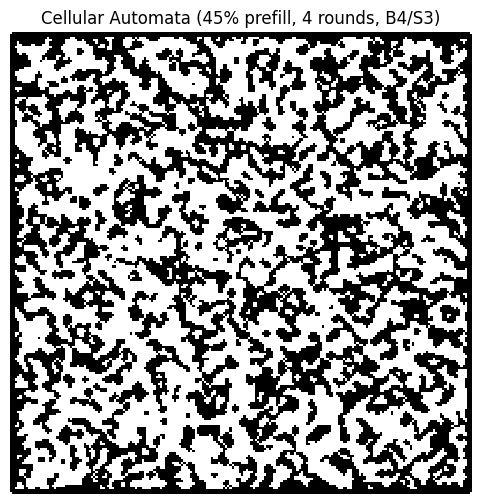

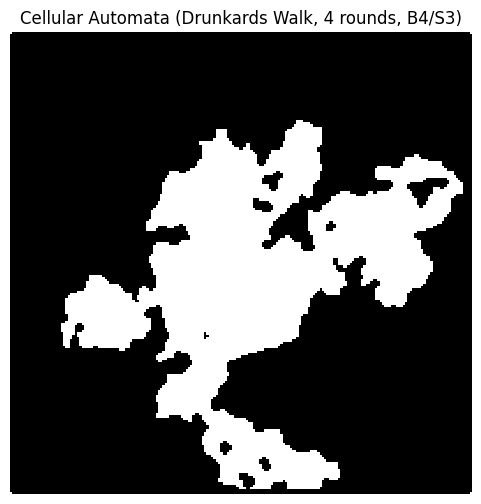

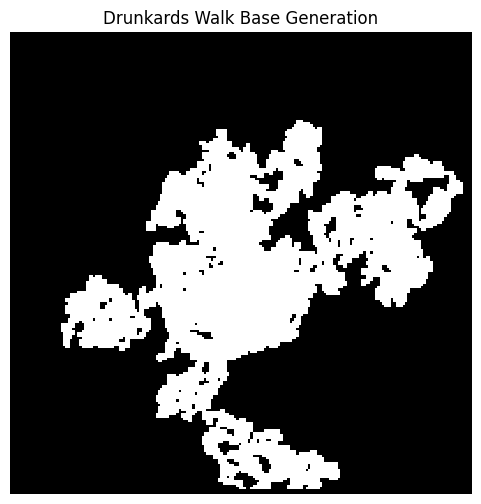

In [ ]:

def generate_cellular_automata(
    rounds: int = 5,
    birth: int = 4,
    death: int = 3,
    live: int = AIR,
    dead: int = WALL,
) -> Generator:
    live_brush = Brush(size=1, value=live)
    dead_brush = Brush(size=1, value=dead)

    def generator(context: Context) -> None:
        for _ in range(rounds):
            current = context.copy()

            for x in range(0, context.width):
                for y in range(0, context.height):
                    count = current.neighbours_for(x, y, live)

                    if count < death:
                        context.draw(x, y, dead_brush)

                    if count > birth:
                        context.draw(x, y, live_brush)

    return generator


render(
    chain(
        generate_random(ratio=0.4),
        generate_frame(brush=Brush(size=2, value=WALL)),
        generate_cellular_automata(rounds=4, birth=4, death=3),
    ),
    title="Cellular Automata (45% prefill, 4 rounds, B4/S3)",
)

_seed = random.randint(0, 2 ** 64 - 1)

render(
    chain(
        generate_drunkard(ratio=0.25, max_steps=4000),
        generate_frame(brush=Brush(size=2, value=WALL)),
        generate_cellular_automata(rounds=4, birth=4, death=3),
    ),
    title="Cellular Automata (Drunkards Walk, 4 rounds, B4/S3)",
    seed=_seed
)

render(
    chain(
        generate_drunkard(ratio=0.25, max_steps=4000),
        generate_frame(brush=Brush(size=2, value=WALL)),
    ),
    title="Drunkards Walk Base Generation",
    seed=_seed
)


## Room Based Generators

Room based generators are a subset of procedural generation that generate maps by
placing rooms, and then connecting them via corridors.

They have an advantage over the basic generators in that the rooms can be used to
more easily place place points of interest, but often have less variety in the shape.

To generate a room based dungeon we first generate a set of non overlapping rectangles,
and calculate the edges that connect them to other rooms, then we carve out the rooms
and connect them with tunnels.

In [ ]:
def generate_rooms(
    rooms: RoomGenerator,
    edges: EdgeGenerator,
    tunnels: TunnelGenerator,
    inner: Generator = generate_fill()
) -> Generator:

    def generator(context: Context) -> None:
        room_list = rooms(context)
        edge_list = edges(room_list, context.rng)

        for x, y, w, h in room_list:
            inner(context.subcontext(x, y, w, h))

        for i, j in edge_list:
            x1, y1 = center_for_rect(*room_list[i])
            x2, y2 = center_for_rect(*room_list[j])

            tunnels(context, x1, y1, x2, y2)

    return generator


### Naive edge generator

An edge generator that connects rooms in the order they were generated.

In [ ]:
def edge_naive(rooms: list[Rect], rng: random.Random) -> list[tuple[int, int]]:
    return [(i, i + 1) for i in range(len(rooms) - 1)]


### Sorted edge generator

An edge generator that sorts a set of rooms by their x coordinate, and then connects 
them in order.

In [ ]:
def edge_sorted(rooms: list[Rect], rng: random.Random) -> list[tuple[int, int]]:
    indexed = list(enumerate(rooms))

    indexed.sort(key=lambda r: r[1][0])

    return [(indexed[i][0], indexed[i + 1][0]) for i in range(len(rooms) - 1)]


### Simple tunnel generator

A tunnel generator that connects the centres of two rooms by moving once in a straight
line along each of the cardinal axis.

In [ ]:
def tunnel_simple(brush: Brush = Brush(size=3)) -> TunnelGenerator:

    def generator(context: Context, x1: int, y1: int, x2: int, y2: int) -> None:
        if context.rng.randint(0, 1):
            for x in range(min(x1, x2), max(x1, x2) + 1):
                context.draw(x, y1, brush)

            for y in range(min(y1, y2), max(y1, y2) + 1):
                context.draw(x2, y, brush)
        else:
            for y in range(min(y1, y2), max(y1, y2) + 1):
                context.draw(x1, y, brush)

            for x in range(min(x1, x2), max(x1, x2) + 1):
                context.draw(x, y2, brush)

    return generator


### Simple room generator

A room generator that places rooms at random, discarding any that overlap.

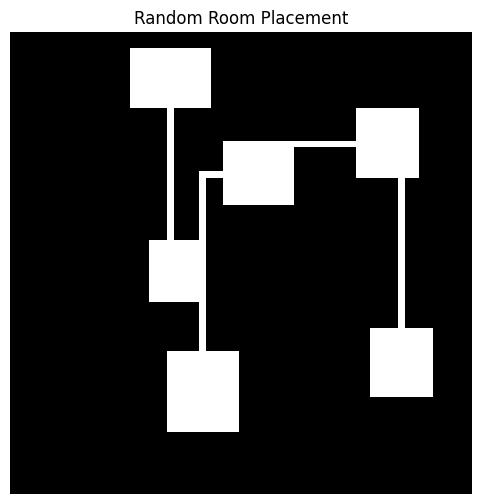

In [ ]:


def room_random(count: int, min_width: int, min_height: int, max_width: int, max_height: int, spacing: int = 1) -> RoomGenerator:

    def generator(context: Context) -> list[Rect]:
        result = []

        for _ in range(count):
            w = context.rng.randint(min_width, max_width)
            h = context.rng.randint(min_height, max_height)

            if w > context.width - spacing * 2 or h > context.height - spacing * 2:
                continue

            x = context.rng.randint(spacing, context.width - spacing - w)
            y = context.rng.randint(spacing, context.height - spacing - h)

            if any(
                x < ox + ow + 1 and
                x + w + 1 > ox and
                y < oy + oh + 1 and
                y + h + 1 > oy
                for ox, oy, ow, oh in result
            ):
                continue

            result.append((x, y, w, h))

        return result

    return generator


render(
    generate_rooms(
        room_random(count=10, min_width=25, min_height=25,
                    max_width=40, max_height=40),
        edge_sorted,
        tunnel_simple(),
    ),
    title="Random Room Placement",
)


### Binary Space Partitioning room generator

This room generator uses binary space partitioning to generate a set of rectangles then
randomly selects some of those rectangles to be rooms.

The rectangles are produced by recursively splitting regions of the map in half along
one of the cardinal axis until the regions are too small to be divided further.

This makes it easier to the desired number of rooms, as assuming a sensible minimum size
is specified to generate enough rectangles, the algorithm should be able place the 
desired number of rooms.

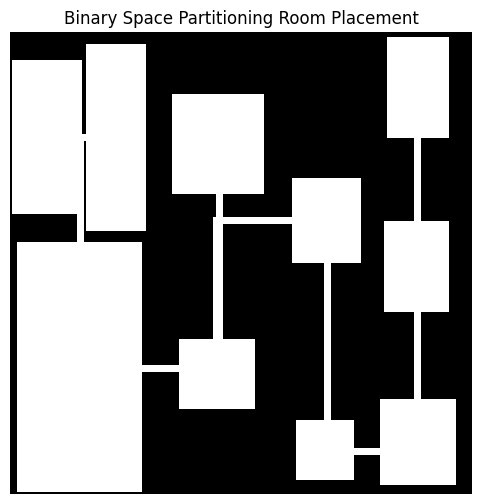

In [ ]:
class BinaryNode[T]:
    value: T
    left: typing.Self | None
    right: typing.Self | None

    def __init__(self, value: T) -> None:
        self.value = value
        self.left = None
        self.right = None

    def to_list(self) -> list[T]:
        if self.left and self.right:
            return [*self.left.to_list(), *self.right.to_list()]

        return [self.value]


def room_bsp(count: int, spacing: int = 1, min_width: int = 30, min_height: int = 30) -> RoomGenerator:

    def generator(context: Context) -> list[Rect]:
        root = BinaryNode((spacing, spacing, context.width -
                          spacing * 2, context.height - spacing * 2))

        nodes = [root]

        size = 1

        while nodes and size < count:
            index = context.rng.randint(0, len(nodes) - 1)

            node = nodes.pop(index)

            x, y, w, h = node.value

            if (context.rng.randint(0, 1) == 1 or h < min_height * 2 + spacing) and w >= min_width * 2 + spacing:
                split = context.rng.randint(min_width, w - min_width - spacing)

                node.left = BinaryNode((x, y, split, h))
                node.right = BinaryNode(
                    (x + split + spacing, y, w - split - spacing, h))

                if split > min_width:
                    nodes.append(node.left)

                if w - split - spacing > min_width:
                    nodes.append(node.right)

                size += 1

            elif h >= min_height * 2 + spacing:
                split = context.rng.randint(
                    min_height, h - min_height - spacing)

                node.left = BinaryNode((x, y, w, split))
                node.right = BinaryNode(
                    (x, y + split + spacing, w, h - split - spacing))

                if split > min_height:
                    nodes.append(node.left)

                if h - split - spacing > min_height:
                    nodes.append(node.right)

                size += 1

        spaces = root.to_list()

        result = []

        for x, y, w, h in spaces:
            iw = context.rng.randint(min_width, w)
            ih = context.rng.randint(min_height, h)
            ix = x + (w - iw) // 2
            iy = y + (h - ih) // 2

            result.append((ix, iy, iw, ih))

        return result

    return generator


render(
    generate_rooms(
        room_bsp(count=10, spacing=1, min_width=25, min_height=25),
        edge_naive,
        tunnel_simple(),
    ),
    title="Binary Space Partitioning Room Placement",
)


## Combined Generators

### BSP + Drunkards Walk + Cellular Automata

By combining BSP and Drunkards Walk we can get a map comprises of an interconnected set of caves.

**TODO:** smarter edge and tunnel generators.

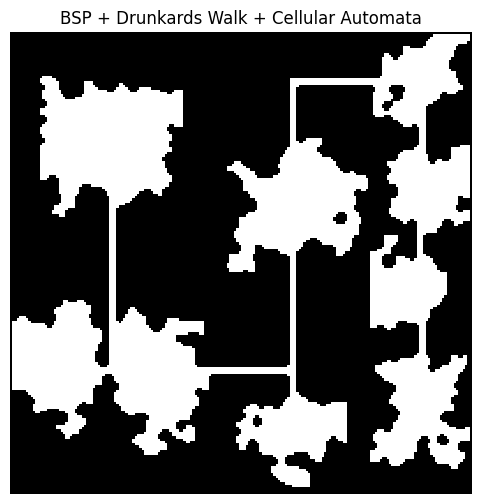

In [ ]:
render(
    chain(
        generate_rooms(
            room_bsp(count=9, spacing=1, min_width=40, min_height=40),
            edge_naive,
            tunnel_simple(),
            chain(
                generate_drunkard(ratio=0.5, max_steps=400,
                                  brush=Brush(size=2)),
            ),
        ),
        generate_cellular_automata(rounds=8),
        generate_frame(),
    ),
    title="BSP + Drunkards Walk + Cellular Automata",
)


### Random Placement (Symmetrical) + Cellular Automata

Combining large random placement with cellular automata can produce interesting cavern
like maps.

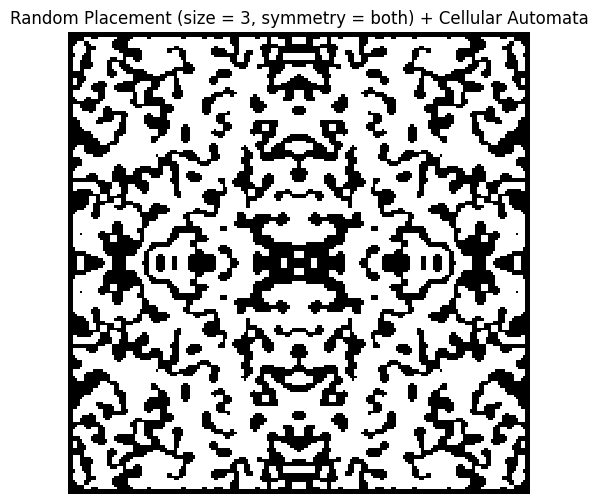

In [ ]:
render(
    chain(
        generate_random_placement(
            ratio=0.5, brush=Brush(size=3, symmetry="both")),
        generate_frame(brush=Brush(size=2, value=WALL)),
        generate_cellular_automata(rounds=8),
        generate_frame(),
    ),
    title="Random Placement (size = 3, symmetry = both) + Cellular Automata",
)


### Drunkards Walk (Symmetrical) + Cellular Automata

Symetrical Drunkards Walk combined with cellular automata gives a nice central cavern
with cave like edges.

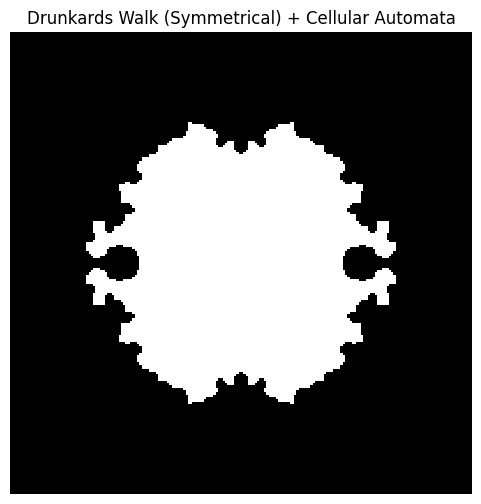

In [ ]:
render(
    chain(
        generate_drunkard(ratio=0.4, max_steps=1000,
                          brush=Brush(size=2, symmetry="both")),
        generate_frame(brush=Brush(size=2, value=WALL)),
        generate_cellular_automata(rounds=8),
        generate_frame(),
    ),
    title="Drunkards Walk (Symmetrical) + Cellular Automata",
)
